# Project 4: Domain Data Preparation
This project will help you familiarize with common data collection and preprocessing tasks. We will mine public text data related to the topic of coronavirus from different sources, and process and combine them to a single corpus, on which we can perform feature engineering to prepare for subsequent analyses.

If you are running this notebook on Google Colab, use the provided code in the next section to set up your environment. If you are running this notebook locally, you can **delete the Environment setup section and start at the Package import section**.

### Environment setup (Google Colab only)
After downloading and extracting the handout tar file, upload all of the handout files to Colab. Run the following cell to list all the file names in the current directory. Make sure you can see `domain_data_preparation.ipynb`, `local_test_refs`, `submitter`, `references`, `pdfs` and `requirements.txt`.

In [ ]:
import os
os.listdir()

Now install all the Python packages needed for the project.

In [ ]:
!pip install -r requirements.txt

Finally, run the following code to get a Chrome webdriver in the current directory:

In [ ]:
!apt-get update
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver .

Now you can import the packages and begin the project!

### Package import

In [1]:
import pandas as pd
import numpy as np
import requests
import json, collections, time, re, string, os
from datetime import datetime

import nltk
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.corpus import wordnet

import bs4
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.common import exceptions

from pdfminer import high_level

In [2]:
# this cell has been tagged with excluded_from_script
# it will not be run by the autograder
%matplotlib inline

## Part A: Text Processing

Text data on the internet is very messy.  Typically there is a fair amount of processing work to do once you have collected any sizeable chunk of text data, in order to have it ready for subsequent analyses. To get you familiar with this kind of data, this section will walk you through some common processing tasks:

The first step is to import the lemmatizer and set of English stopwords from `nltk`:

In [3]:
nltk.download("stopwords", quiet = True)
nltk.download("wordnet", quiet = True)
nltk.download("punkt", quiet = True)
nltk.download('averaged_perceptron_tagger', quiet = True)
lemmatizer = WordNetLemmatizer()
english_stopwords = set(nltk.corpus.stopwords.words('english'))

### Question 1: Text cleaning and tokenization
Implement the three functions `clean_string`, `tokenize` and `lemmatize` that perform the following text preprocessing tasks:

1. `clean_text` should:
    * convert the string to lower case.
    * remove any instance of `'s` that is either followed by any whitespace character, or at the end of the string: `teacher's help` becomes `teacher help`, and `children's` becomes `children`.
    * remove apostrophe character `'`: `don't` becomes `dont`. For simplicity we will only consider the character `'` as apostrophe (so `’` is not).
    * remove leading and trailing space.

1. `tokenize` should:
    * use `nltk.word_tokenize` to tokenize the input text.
    * further break tokens at characters which are not digits 0-9 and not present in `string.ascii_letters`. For example, `a_b_c` becomes `['a', 'b', 'c']`.
    * maintain the token order as it appears in the original string.

1. `lemmatize` should:
    * lemmatize each token individually.
    * remove tokens that are stopwords or contain fewer than two characters (these two cases should be checked after the lemmatization step).
    
**Notes**:
* When lemmatizing a word, you should also specify the part-of-speech `pos` parameter. This can be obtained by calling `nltk.pos_tag` and using the first returned tag (in case there are multiple possibilities). You can interpret the returned tag as follows:
    * If it starts with "J", it is an adjective.
    * If it starts with "V", it is a verb.
    * If it starts with "R", it is an adverb.
    * Otherwise, it is a noun.
* `nltk.pos_tag` should be called on each individual token, instead of on the entire tokenized text. For example, if the input string is `"learning is fun"`, you should call `nltk.pos_tag(["learning"])` to get the part-of-speech of `'learning'`, and input that to the lemmatizer. You may notice that in this case `"learning"` is classified as a verb (while it is a noun in the original sentence). However, this is not a problem, since our end goal is to reduce each token to its base form, not to correctly classify its part-of-speech.
* If you use the regex character set `\w`, note that it matches alphanumeric characters **and** the underscore character `_`.

In [6]:
def clean_text(text):
    """
    Clean the input string by converting it to lowercase, removing 's and apostrophe.
    
    args:
        text (str) : the input text
        
    return:
        str : the cleaned text
    """
    text = text.lower()
    text = re.sub("'s$", " ",text)
    text = re.sub("'s\s"," ",text)
    text = text.replace("'", "")
    text = text.strip()
    return text


def tokenize(cleaned_text):
    """
    Tokenize the input string.
    
    args:
        cleaned_text (str): the input text, output from clean_text
        
    return:
        List[str] : a list of tokens from the input text
    """

    tokenized_list = nltk.word_tokenize(cleaned_text)
    all_tokens = []
    for tokens in tokenized_list:
        tokens_new = re.split('[^a-zA-Z0-9]+', tokens)
        all_tokens.extend(token for token in tokens_new if token)
    return all_tokens



def lemmatize(tokens, stopwords = {}):
    """
    Lemmatize each token in an input list of tokens
    
    args:
        tokens (List[str]) : a list of token, output from tokenize
    
    kwargs:
        stopwords (Set[str]) : the set of stopwords to exclude
    
    return:
        List[str] : a list of lemmatized and filtered tokens
    """
    def getPosValue(pos):
        if pos.startswith('J'):
            pos_val = 'a'
        elif pos.startswith('V'):
            pos_val = 'v'
        elif pos.startswith('R'):
            pos_val = 'r'
        else:
            pos_val = 'n'
        return pos_val
            
    lemmatized_list = []
    for token in tokens:
        pos_tag_list = nltk.pos_tag([token])
        
        for token, pos in pos_tag_list:
            pos_value = getPosValue(pos)
            
            lemmatized_tokens = lemmatizer.lemmatize(token, pos=pos_value) 
            if lemmatized_tokens not in stopwords and len(lemmatized_tokens)>=2:
                lemmatized_list.append(lemmatized_tokens)
                
    return lemmatized_list


def preprocess_text(text, stopwords = {}):
    # do not modify this function
    cleaned_text = clean_text(text)
    tokens = tokenize(cleaned_text)
    return lemmatize(tokens, stopwords)


In [7]:
def test_preprocess_text():
    # cleaning
    assert clean_text("I like Data Science") == "i like data science"
    assert clean_text("She's") == "she"
    assert clean_text("you've")== "youve"
    assert clean_text("car, cars, car's cars'")== "car, cars, car cars"
    assert clean_text("'shed'") == "shed"
    assert clean_text("'good news'") == "good news"
    assert clean_text("CMU's campus")== "cmu campus"
    assert preprocess_text("abc 'system") == ['abc', 'system']
    assert preprocess_text("O'Shea Jackson Jr. is an American actor and musician") == ['oshea', 'jackson', 'jr', 'be', 'an', 'american', 'actor', 'and', 'musician']
    
    # tokenization
    assert tokenize("ab..ab. .ab . ab.") == ['ab', 'ab', 'ab', 'ab'], tokenize("ab..ab. .ab . ab.")
    assert tokenize("word-of-mouth hello,world")== ['word', 'of', 'mouth', 'hello', 'world']
    assert tokenize("gotta")== ['got', 'ta']
    assert tokenize("hello_world") == ["hello", "world"]
    assert preprocess_text("hope this👏will work") == ['hope', 'this', 'will', 'work']
    
    # lemmatization
    assert lemmatize(["cats"]) == ['cat']
    assert lemmatize(["did"]) == ['do']
    assert lemmatize(["learning", "is", "fun"], english_stopwords) == ["learn", "fun"]
    
    # miscellaneous
    assert preprocess_text("the weather is really nice", english_stopwords) == ['weather', 'really', 'nice']
    assert preprocess_text(
        "To apply SVM learning in partial discharge classification, data input is very important!?",
        english_stopwords
    ) == 'apply svm learn partial discharge classification data input important'.split()
    assert preprocess_text("after all he's done", english_stopwords) == []
    assert preprocess_text("they didn’t have much chance of guessing what it was without further clues.", english_stopwords) == ['much', 'chance', 'guess', 'without', 'far', 'clue']
    assert preprocess_text("DUQUE'S", english_stopwords) == ["duque"]
    assert preprocess_text("the 'rona", english_stopwords) == ['rona']
    assert preprocess_text('MOTORCYCLES DONT FLY', english_stopwords)==['motorcycle', 'dont', 'fly']
    assert preprocess_text('“ Georg e\”', english_stopwords) == ['georg']
    text = "Harry leapt into the air; he’d trodden on something big and squashy on the doormat — something alive"
    assert preprocess_text(text, english_stopwords) == ['harry', 'leapt', 'air', 'trodden', 'something', 'big', 'squashy', 'doormat', 'something', 'alive']
    assert preprocess_text("Donâ€™t want to add to TRUMPâ€™s #COVID19 numbers. #CoronaVirus ðŸ¦  donâ€™t care.", english_stopwords) == ['want', 'add', 'trump', 'covid19', 'number', 'coronavirus', 'care']
    
    # test on long text string
    with open("local_test_refs/henrys_letter.txt", encoding = "utf-8") as infile, open("local_test_refs/processed_henrys_letter.txt", encoding = "utf-8") as outfile:
        processed_str = preprocess_text(infile.read())
        reference_str = outfile.read().splitlines()
        assert processed_str == reference_str
    print("All tests passed!")

test_preprocess_text()

All tests passed!


You may notice that the lemmatization functionality isn't perfect; for example, it would map `"as"` to `"a"` because `"as"` is being treated as a noun instead of a proposition (with tag `"IN"`). In general, identifying the correct part-of-speech tag is very context-dependent (for example, `"back"` can be either an adjvective, adverb, verb or noun). In the context of this project, we will not dive deep into these linguistic nuances, and settle with the lemmatization rules above.

The above processing function already covers a fair number of text cleaning tasks. We can now begin to collect data from online sources.

## Part B: Tweet Mining

Twitter is one of the most popular social media platforms; according to [Omnicore](https://www.omnicoreagency.com/twitter-statistics/#:~:text=There%20are%2048.35%20million%20monthly,monetizable%20daily%20active%20Twitter%20users.), it has 48.35 million active users, 42% of whom use Twitter on a daily basis. Furthermore, tweets are public by default, making the site a particularly rich data source on any given trending topic.

In this section, you will extract tweets related to the topic of coronavirus. Due to the dynamic nature of Twitter, any user can edit or remove their old tweets, making it difficult to obtain deterministic results (and to autograde your code). Therefore, we will instead use a fixed Tweet [dataset from Kaggle](https://www.kaggle.com/smid80/coronavirus-covid19-tweets) and provide you with a custom API to query tweets from this dataset. For your own data science projects in the future, however, you are encouraged to explore the [official Twitter API](https://developer.twitter.com/en/docs).

### Question 2: Retrieve starting tweets
Implement the function `get_tweets` that sends a GET request to https://gettweets.azurewebsites.net/11637/tweets and returns the status code as well as the response JSON. The response JSON is a list of dictionaries, each corresponding to one tweet and having the following format:

```python
{
    'text': 'hello world', # str, the tweet content
    'lang': 'en', # str, the tweet language
    'id': 123, # int, the tweet id
    'time': '2019-12-04' # # str, yyyy-mm-dd
}
```

**Notes**:
* The API endpoint url https://gettweets.azurewebsites.net/11637/tweets is provided in the global variable `TWEET_API`.
* You should call `.text` on the response object to retrieve its content, and then convert the content to JSON before returning.

In [8]:
TWEET_API = "https://gettweets.azurewebsites.net/11637/tweets"

def get_tweets(url = TWEET_API):
    """
    Retrieve tweets by sending a GET request to the provided API endpoint.
    
    params:
        url (str) : the url to send request to
    
    return:
        Tuple(status_code, response):
            status_code (int) : the response status code
            response (str) : the response text
    """
    response = requests.get(url)
    return (response.status_code, response.text)


In [9]:
def test_get_tweets():
    response_code, tweet_text = get_tweets()
    tweet_jsons = json.loads(tweet_text)
    assert response_code == 200
    assert len(tweet_jsons) == 100
    first10_tweet_ids = [tweet_json["id"] for tweet_json in tweet_jsons[:10]]
    assert first10_tweet_ids == [2819, 3075, 3331, 3587, 3843, 4099, 4355, 4611, 4867, 5123]
    assert tweet_jsons[1]["text"] == 'Los Angeles County has identified 6 new cases of the coronavirus &amp; declared a local state of emergency.\n#CoronavirusOutbreak #Coronavirusflorida #LosAngeles'
    print("All tests passed!")

test_get_tweets()

All tests passed!


Great, you now have 100 tweets at your disposal! Typically though, we would like to have more flexibility in our search, for example by specifying particular parameters that indicate our search objective. In this case, our API provides four parameters as follows:

* `lang` - specify the tweet language, which is an [ISO 639-1 code](https://en.wikipedia.org/wiki/List_of_ISO_639-1_codes), e.g., `en` for English.
* `start` - the start date, formatted as yyyy-mm-dd; only tweets created on or after this date are returned.
* `end` - the end date, formatted as yyyy-mm-dd; only tweets created on or before this date are returned.
* `page` - the tweet page number.

Note the use of the `page` parameter here. Because returning a large JSON would put burden on the server, we have restricted all response JSONs to only include 100 tweets. To get more tweets that also satisfy your search query, you can specify the `page` parameter based on the following formula: if `page = i` (indexed from 1) then the tweets from index `100*(i-1) + 1` to index `100*i` (inclusive) will be returned.

As an example, if your configuration of `(lang, start, end)` yields 306 tweets, then:

* `page = 1` or no `page` specified will return the tweets 1-100.
* `page = 2` will return the tweets 101-200.
* `page = 3` will return the tweets 201-300.
* `page = 4` will return the tweets 301-306.
* `page = 5` or larger will return a JSON with empty content `"[]"`.

### Question 3: Search for tweets with parameters
Implement the function `get_tweet_texts_with_params` that sends a GET request to the provided API endpoint with (optional) input parameters `lang`, `start`, `end` and `page`. This function should collect all tweets that satisfy the search query if the number of such tweets is smaller than a specified `n_tweets`, or the first `n_tweets` tweets otherwise.

In [10]:
def get_tweet_texts_with_params(url = TWEET_API, lang = "all", start = "na", end = "na", n_tweets = 10000):
    """
    Search for tweets with parameters and extract their text content
    
    kwargs:
        url (str) : the url to send request to
        lang (str) : the tweet language in ISO 639-1 format
        start (str) : the start date, yyyy-mm-dd
        end (str) : the end date, yyyy-mm-dd
        n_tweets (int) : the number of tweets to collect
    
    return:
        List[str] : a list with the contents of the first n_tweets tweets returned from the search
    """
    
    tweet_list = []
    page = 1
    
    while len(tweet_list) < n_tweets:
        params ={"lang": lang, "start": start, "end": end, "page": page}
        response = requests.get(url, params=params)
            
        for tweet in response.json():
            tweet_list.append(tweet['text'])
            
        page+=1
    
    return tweet_list

In [11]:
def test_get_tweet_texts_with_params():
    tweet_texts = get_tweet_texts_with_params(lang = "en", start = "2020-03-09", end = "2020-03-09")
    assert len(tweet_texts) == 10000
    example_tweets = [
        '#coronavirus #COVID19 2 new cases reported in Kentucky (Harrison Co and Fayette Co), bring the states total to 6.',
        "#BREAKING\n#Italy is extending its #coronavirus #quarantine measures, which include a ban on public gatherings, to the ENTIRE COUNTRY.\nItaly's coronavirus death toll jumped on Monday by 97 to 463. \nIt is the worst-hit country after #China.\nhttps://t.co/Q6MNtyXttA\n#COVID19",
        '#Investorsâ€™ fortunes plunge as sell pressure hit banking stocks amid COVID-19 fear https://t.co/stihfvM7xZ via @MarketForcesA\n\n@Afrinvest @nsenigeria #equitymarket #fmcg #banks #insurance #oilandgas #COVID19',
        'FROM A DOCTOR IN ITALY...\n#coronavirus\n#Coronavirusflorida\n#CoronaVirusUpdates\n#CoronavirusUSA\n#COVID19 \n#covid19Canada\n#COVID19Toronto\n#CoronaVirusCanada \n#coronavirusToronto https://t.co/ZelZHWTuR1',
        'Ina joint statement, Major League Baseball, Major League Soccer, the National Basketball Association, and the National Hockey League announced they are limiting locker room access due to concerns about the Coronavirus pandemic. #MLB #MLS #NBA #NHL #COVID19 #coronavirus https://t.co/Z6CUqxDrAO',
        'Coronaviruses (CoV) are a large family of viruses that cause illness ranging from the common cold to more severe diseases such asMERS-CoVand SARS-CoV. A novel coronavirus (nCoV) is a new strain that has not been previously identified in humans.  #coronavirus #CoronavirusOutbreak',
        'Simon Coveny and the entire Irish government attitude towards #covid19 just got destroyed on  #cblive',
        'The reason for the toilet paper shortage is because when one person sneezes, 100 people shit themselves ðŸ¤§ #coronavirus #COVID19 #tolietpaper',
        'Latest #COVID19 numbers in Missouri - https://t.co/27vLQ3ZmqY',
        'Tips on battling #CoronaVirusUpdate #COVID2019 #CoronavirusOutbreak \nhttps://t.co/UaY8boPzHg'
    ]
    
    assert tweet_texts[800:810] == example_tweets
    emoji_tweet = "Be carefull guy's and wish you all happy holi to you &amp; your family. :) \n#HappyHoli #CoronavirusOutbreak #à¤¹à¥‹à¤²à¥€ #à¤¹à¥‹à¤²à¤¿à¤•à¤¾_à¤¦à¤¹à¤¨ #BankLooteriBJP #Coronavid19 #marketcrash  #reliance #colours #KurkureWithSidNaaz #MondayMorning #MereAngneMein ##RangBarseWithSid #à¤¬à¥�à¤°à¤¾_à¤¨_à¤®à¤¾à¤¨à¥‹_à¤¹à¥‹à¤²à¥€_à¤¹à¥ˆ https://t.co/Rg2SpMNKZD"
    assert emoji_tweet in tweet_texts
    print("All tests passed!")
    
test_get_tweet_texts_with_params()

All tests passed!


### Question 4: Process tweet data
Looking at some of the tweets above, we see that:
1. Some tweets contain Twitter-shortened URLs, for example `https://t.co/DzhsXPxUDa`. These are always in the form of `http://t.co/` or `https://t.co/` followed by 10 alphanumeric characters. These links should be removed.
1. Some tweets contain emoticons such as `:)` or `<3`. The characters in these emoticons should be removed.

Implement the function `process_tweet` that takes as input a tweet text, performs the above two cleaning steps, and then calls `preprocess_text` on the cleaned tweet.

**Notes**:
* You should remove URL before removing emoticons.
* We have provided a list of emoticons for you in the variable `emoticons`. You can assume that only elements in this set are considered emoticons and need to be removed. 
* Note that there may be no space between a shortened URL and the next word. However, you can assume that there are always 10 alphanumeric characters after http://t.co/ or https://t.co/.
* Remember to specify the stopwords parameter `english_stopwords` when calling `preprocess_text`.

In [12]:
emoticons = [
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)', '<3',
    ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', 'b=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';('
]


def process_tweet(tweet_text):
    """
    Process and tokenize tweets, in addition to removing URLs and emoticons
    
    args:
        tweet_text (str) : a list of tweet contents
    
    return:
        List[str] :  a list of processed tokens from the input tweet
    """
    
    clean_text = re.sub('http.*?t\\.co/\\w{10}', ' ', tweet_text)
    
    for emoticon in emoticons:
        clean_text = clean_text.replace(emoticon, ' ')
    
    processed_tweets = preprocess_text(clean_text, stopwords = english_stopwords)
    return processed_tweets

# do not modify this function
def process_tweet_data(tweet_texts):
    return [process_tweet(tweet_text) for tweet_text in tweet_texts]

In [13]:
def test_process_tweet():
    assert process_tweet("It's a great day :D") == ['great', 'day']
    assert process_tweet("<3hello") == ["hello"]
    assert process_tweet("goodX-Dday") == ["good", "day"]
    assert process_tweet("http://t.co/WJs5bmRthU,http://t.co/WJs5bmRthU,") == []
    assert process_tweet("hellohttp://t.co/WJs5bmRthUworld") == ["hello", "world"]
    assert process_tweet("http://taco/WJs5bmRthU") == ['http', 'taco', 'wjs5bmrthu']
    assert process_tweet(
        'Protect your child from #CoronavirusOutbreak.\n\nhttps://t.co/qPREVvM2C5\n\n#CoronaVirusUpdate #COVID2019 #COVID #Coronavid19 #outbreak #Italy #COVIDãƒ¼19 #BeSafe #Containment #Homeschooling #DigitalTransformation #InternationalSchooling #virtualschool #OnlineNOW #edtech #technology'
    ) == ['protect', 'child', 'coronavirusoutbreak', 'coronavirusupdate', 'covid2019', 'covid', 'coronavid19', 'outbreak', 'italy', 'covid', '19', 'besafe', 'containment', 'homeschooling', 'digitaltransformation', 'internationalschooling', 'virtualschool', 'onlinenow', 'edtech', 'technology']
    print("All tests passed!")
    
test_process_tweet()

All tests passed!


## Part C: Web Scraping

We now move to the second method of data extraction: using Selenium and Beautifulsoup to parse HTML codes. More specifically, we will collect news articles related to the same topic of Coronavirus from two major media outlets -- [Nature](https://www.nature.com/) and [The New York Times](https://www.nytimes.com/). Through this exercise, you will learn how to navigate HTML structures from different webpages in order to get the desired information.

To begin, we have provided you a helper function `retrieve_url` takes as input a webpage string URL and creates a BeautifulSoup object from the corresponding page content.

In [14]:
def retrieve_url(url):
    page = requests.get(url)
    soup = BeautifulSoup(page.content, 'html.parser')
    return soup

### Question 5: Parsing a single article from Nature
Implement the function `parse_page_nature` that takes as input a URL string pointing to a Nature news article, and returns a JSON dictionary with the following format:

```python
{
    'Title': 'When will the coronavirus outbreak peak?' #str
    'Author': ['David Cyranoski'] # list, a list of author names in the same order as they appear on the page
    'Published Date': '2020-04-21' # str, yyyy-mm-dd
    'Summary': '.....' #str, the summary div between the title and author fields, or empty string if no summary is available
    'Content': '.....' #list, the whole article content, where every element is a paragraph (i.e., comes from a <p> tag)
}
```

The values of `Summary` and `Content` should be raw texts that do not contain any HTML tag. For example, if the input HTML code is `"<p><b>Hello</b><a href="https://google.com">World</a><p>"` then the output `Content` should be `"Hello World"`.

In the local test we have provided the full reference JSON files for some article pages. If your dictionary does not match the reference JSON, you should print out both and do a careful comparison to see where the difference is.

**Notes**:
* Occasionally there are some "Related" blocks embedded in the article text (example [here](http://clouddatascience.blob.core.windows.net/m20-foundation-data-science/p3-domain-data-preparation/nature_related.png)). These are characterized by the attribute `data-label="Related"` and should **not** be included in the parsing result.
* The `Published Date` field should be the original article date, not the updated date. For example, the `Published Date` for [this article](http://web.archive.org/web/20210308142952/https://www.nature.com/articles/d41586-020-00166-6) is 2020-01-22.
* Remember to call `strip()` on all values in the returned dictionary so that there is no leading or trailing space anywhere. If a content paragraph becomes empty after `strip()`, it should not be included. You do not need to call any other text processing task in section A.
* Do not parse information form the `meta` tags as they are not robust. Every required information can be found within `body`.
* If an article has no authors (e.g., [this article](http://web.archive.org/web/20201116084933/https://www.nature.com/articles/d41586-020-00589-1)), the Author field should be an empty list.
* For the Content list, only text contents that come from the `p` tags in the article body should be included. You can start by identifying a `div` that corresponds to the entire article body (looking at the CSS class names may be helpful). Note that if an image caption is the child of a `p` tag, its content should be included as well.

In [17]:
def parse_page_nature(url):
    """
    Parse a single New York Times article at the given URL
    
    args:
        url (str) : the article URL
    
    return:
        Dict[str, str] : the parsed information stored in JSON format, which includes:
            Title, Author, Published Date, Summary and Content
    """
    soup = retrieve_url(url)
    json_dict = {'Title': '', 'Author':[], 'Published Date': '', 'Summary':'', 'Content':[]}
    
    title = soup.find("h1", class_="article-item__title")
    if title:
        json_dict['Title'] = title.text.strip()
    
    
    authors_list = []
    index = 0
    while True:
        author_find_str = "author-affiliation-news-" + str(index) + "-head"
        author = soup.find("h3", id=author_find_str)
        if author:
            author_name = author.text.strip()
            if '&' in author_name:
                author_name = author_name.replace('&','').strip()
            authors_list.append(author_name)
        else:
            break
        index += 1 
    if authors_list:
        json_dict['Author'] = authors_list
    
    
    date = soup.find("time", itemprop="datePublished")
    if date:
        date_str = date.text.strip()
        date_new = datetime.strptime(date_str, "%d %B %Y")
        date_new = date_new.strftime("%Y-%m-%d")
        json_dict['Published Date'] = date_new
    
    summary = soup.find("div", class_ = "article-item__teaser-text")
    if summary:
        json_dict['Summary'] = summary.text.strip()

   
    content = soup.find("div", class_ = "article__body")
    if content:
        for related_block in content.find_all(attrs={"data-label": "Related"}):
            related_block.decompose()
        
        paragraphs_list = content.find_all("p")

        if paragraphs_list:
            json_dict['Content'] = [para.text.strip() for para in paragraphs_list if para.text.strip() != ""]

    return json_dict

In [18]:
def test_parse_page_nature():
    nature1 = parse_page_nature("http://web.archive.org/web/20200430055159/https://www.nature.com/articles/d41586-020-00190-6")
    nature1_reference = json.load(open("local_test_refs/nature1.txt"))
    assert nature1 == nature1_reference, nature1
    
    nature2 = parse_page_nature("http://web.archive.org/web/20210308142952/https://www.nature.com/articles/d41586-020-00166-6")
    nature2_reference = json.load(open("local_test_refs/nature2.txt"))
    assert nature2 == nature2_reference, nature2
    
    nature3 = parse_page_nature("http://web.archive.org/web/20200604083109/https://www.nature.com/articles/d41586-020-00798-8")
    nature3_reference = json.load(open("local_test_refs/nature3.txt"))
    assert nature3 == nature3_reference, nature3
    
    nature4 = parse_page_nature("http://web.archive.org/web/20201116084933/https://www.nature.com/articles/d41586-020-00589-1")
    assert nature4["Author"] == []
    assert nature4["Published Date"] == '2020-03-04'
    assert len(nature4["Content"]) == 26
    
    nature5 = parse_page_nature("http://web.archive.org/web/20200604071303/https://www.nature.com/articles/d41586-020-00786-y")
    assert nature5["Author"] == ['Giuliana Viglione']
    assert nature5["Published Date"] == '2020-03-16'
    assert len(nature5["Content"]) == 14
    print("All tests passed!")

test_parse_page_nature()

All tests passed!


### Question 6: Parsing several Nature articles from a search page
Now that you have successfully parsed individual article pages, the next step is to search for all the relevant articles and collect their titles. More specifically, we want to search for articles that:
1. contain the term "coronavirus" (case-insensitive) *in their titles*
1. do not contain any of the terms "Daily briefing", "Podcast" or "Backchat" (case-insensitive) in their titles
1. were published in a given period of time (e.g., February 01, 2020 to March 01, 2020 inclusive)
1. have "News" as the Article type and belong to the journal "Nature" -- these criteria can be specified in the search result page.

Explore the [Nature search page](https://www.nature.com/search) and [Advanced search page](https://www.nature.com/search/advanced) to see how you may obtain the desired search results. Then implement the function `extract_nature_articles` that returns a list of titles for articles that meet the search criteria.

**Notes**:
* You do not need Selenium for this question. Pay attention to how the search parameters are reflected in the URL.
* The article titles should be ordered based on their associated dates **on the search result page**, from earlier to later. If two articles have the same date, order them alphabetically based on their titles.
* If Nature's search functionalities do not support all of the search criteria, you can implement your own filter.

In [19]:
def extract_nature_articles(start_date, end_date, base_url = "https://www.nature.com"):
    """
    Search for and parse all coronavirus-related News article from the Nature journal that were
    published in a given period
    
    args:
        start_date (str): the lower bound of the date range to filter articles,
            has the format yyyy-mm-dd
        end_date (str): the upper bound (inclusive) of the date range to filter articles,
            has the format yyyy-mm-dd
    
    kwargs:
        base_url (str): the home page url of Nature
    
    return:
        List[str] : a list of article titles that meet the search criteria, ordered by
            date and by title
    """
    
    start_year = start_date.split("-")[0]    
    end_year = end_date.split("-")[0] 
    search_url = (base_url + "/search?title=coronavirus&journal=nature&article_type=news&date_range="+start_year+"-"
    +end_year+"&order=date_asc")
    
    page = requests.get(search_url)
    soup = BeautifulSoup(page.content, 'html.parser')
    
    articles = soup.find_all("article")
    filtered_titles = []

    for article in articles:
        article_link = article.find("a", class_="c-card__link u-link-inherit")
        if article_link:
            title = article_link.text.strip()
            unwanted_keywords = ["Daily briefing", "Podcast", "Backchat"]
        if not any(keyword.lower() in title.lower() for keyword in unwanted_keywords):
            date = article.find("time", itemprop="datePublished")
            if date:
                date_str = date.text.strip()
                date_new = datetime.strptime(date_str, "%d %b %Y")
                start_date_new = datetime.strptime(start_date, '%Y-%m-%d')
                end_date_new = datetime.strptime(end_date, '%Y-%m-%d')

            if start_date_new <= date_new <= end_date_new:
                filtered_titles.append((date_new, title))
       
    filtered_titles.sort(key=lambda x: (x[0], x[1]))

    all_titles = [title for date, title in filtered_titles]
    return all_titles

In [20]:
def test_extract_nature_articles():
    parsed_titles = extract_nature_articles("2020-02-01", "2020-03-01")
    expected_titles = [
        'HIV vaccine failure, coronavirus papers and an unprecedented glimpse of the Sun',
        'Did pangolins spread the China coronavirus to people?',
        'How scientists are fighting the novel coronavirus: A three minute guide',
        'CRISPR enhancement, coronavirus source and a controversial appointment',
        'Scientists fear coronavirus spread in countries least able to contain it',
        'More than 80 clinical trials launch to test coronavirus treatments',
        'When will the coronavirus outbreak peak?',
        'Coronavirus name, animal-research data and a Solar System snowman',
        'Scientists question China’s decision not to report symptom-free coronavirus cases',
        'China set to clamp down permanently on wildlife trade in wake of coronavirus',
        '‘No one is allowed to go out’: your stories from the coronavirus outbreak',
        'Time to use the p-word? Coronavirus enters dangerous new phase',
        'Mystery deepens over animal source of coronavirus'
    ]
    expected_dates = [
        '2020-02-05', '2020-02-07', '2020-02-07', '2020-02-12',
        '2020-02-13', '2020-02-15', '2020-02-18', '2020-02-19',
        '2020-02-20', '2020-02-21', '2020-02-21', '2020-02-25', '2020-02-26'
    ]
    
    assert len(parsed_titles) == 13
    assert parsed_titles == expected_titles, parsed_titles
    print("All tests passed!")

test_extract_nature_articles()

All tests passed!


To reduce bias in our data, it is typically a good idea to collect data from more than one source. Below are two **optional** challenges that involve the same web scraping process but on a different news site -- New York Times. Because it has a completely distinct HTML structure from Nature, you will need to inspect the webpage to identify the tags that contain the required information. The second optional challenge (Question 8) will also involve using Selenium to dynamically collect the search result. If you like to test your web scraping skill, give these questions a try.

### Question 7: Parsing a single article from the New York Times (Optional)

 **This is an optional, ungraded question. Feel free to proceed to Question 9 and revisit this later if you are interested.** 

Implement the function `parse_page_nyt` that takes as input an NYT article string URL and returns a JSON dictionary with the following format:

```python
{
    'Title': 'F.D.A. Approves First Coronavirus Antibody Test in U.S.' #str
    'Author': ['Katie Thomas', 'Natasha Singer'] # list, a list of author names in the same order as they appear on the page
    'Published Date': '2020-04-21' # str, yyyy-mm-dd
    'Summary': '.....' #str, the summary paragraph between the title and author fields, or empty string if no summary is available
    'Content': '.....' #list, the whole article content, where every element is a paragraph (i.e., comes from a <p> tag)
}
```

The values of `Summary` and `Content` should be raw text that do not contain any HTML tag. For example, if the input HTML code is `"<p><b>Hello</b> <a href="https://google.com">World</a><p>"` then the output should be `"Hello World"`.

In the local test we have provided the full reference JSON files for some article pages. If your dictionary does not match the reference JSON, you should print out both and do a careful comparison to see where the difference is.

**Notes**:
* Ignore the "Frequently Asked Questions and Advice" box (example [here](http://clouddatascience.blob.core.windows.net/m20-foundation-data-science/p3-domain-data-preparation/nyt_faq.png)).
* The summary can be extracted from a `<p>` tag whose id is `article-summary`. If this tag is not present, simply use the empty string as the value.
* For the `Content` field, you only need to find the `<p>` tags inside the `<div>` tags that have the class `StoryBodyCompanionColumn`.
* You may find unicode characters, e.g., `\u201d`, while parsing the page. It is fine to include them in the output. 
* Remember to call `strip()` on all values in the returned dictionary so that there is no leading or trailing space anywhere. If a content paragraph becomes empty after `strip()`, it should not be included. You do not need to call any other text processing task in section A.

In [21]:
def parse_page_nyt(url):
    """
    Parse a New York Times article page to extract the title, authors, date, summary and content.
    
    args:
        url (str) : the article page's URL
    
    return:
        Dict[str, str] : a JSON-like dictionary whose keys are "Title", "Author", "Published Date", "Summary" and "Content"
    """
    pass

In [ ]:
def test_parse_page_nyt():
    nyt1 = parse_page_nyt("https://web.archive.org/web/20200603034948/https://www.nytimes.com/2020/04/21/health/fda-in-home-test-coronavirus.html")
    nyt1_reference = json.load(open("local_test_refs/nyt1.txt"))
    assert nyt1 == nyt1_reference
    
    nyt2 = parse_page_nyt("https://web.archive.org/web/20200602022004/https://www.nytimes.com/2020/04/18/health/kidney-dialysis-coronavirus.html")
    nyt2_reference = json.load(open("local_test_refs/nyt2.txt"))
    assert nyt2 == nyt2_reference
    
    nyt3 = parse_page_nyt("https://web.archive.org/web/20200520224040/https://www.nytimes.com/2020/03/23/health/medical-students-coronavirus.html")
    nyt3_reference = json.load(open("local_test_refs/nyt3.txt"))
    assert nyt3 == nyt3_reference
    
    nyt4 = parse_page_nyt("https://web.archive.org/web/20200626171621/https://www.nytimes.com/2020/03/23/health/medical-students-coronavirus.html")
    assert nyt4["Author"] == ['Penina Krieger', 'Abby Goodnough']
    assert nyt4["Published Date"] == "2020-03-23"
    assert len(nyt4["Content"]) == 27
    
    nyt5 = parse_page_nyt("https://web.archive.org/web/20200809005447/https://www.nytimes.com/2020/03/20/health/coronavirus-data-logarithm-chart.html")
    assert nyt5["Author"] == ["Kenneth Chang"]
    assert nyt5["Published Date"] == "2020-03-20"
    assert len(nyt5["Content"]) == 8

    nyt6 = parse_page_nyt("https://web.archive.org/web/20200710083045/https://www.nytimes.com/2020/03/20/health/coronavirus-italy-men-risk.html")
    assert nyt6["Author"] == ['Roni Caryn Rabin']
    assert nyt6["Published Date"] == "2020-03-20"
    assert len(nyt6["Content"]) == 17
    
    nyt7 = parse_page_nyt("https://web.archive.org/web/20200522153110/https://www.nytimes.com/2020/03/20/health/coronavirus-nurses-healthcare.html")
    assert nyt7["Author"] == ['Emma Goldberg']
    assert nyt7["Published Date"] == "2020-03-20"
    assert len(nyt7["Content"]) == 20

    print("All tests passed!")

test_parse_page_nyt()

### Question 8: Parsing several NYT article titles from the search page (optional)

 **This is an optional, ungraded question. Feel free to proceed to Question 9 and revisit this later if you are interested.** 
 
Just like with Nature, we can browse the [NYT search page](https://www.nytimes.com/search) and programmatically collect all the search results, which can then be parsed individually using `parse_page_nyt`.

A caveat here is that the Nature search page partitions the search results into several webpages, each with a unique URL, while NYT includes all the search results in one webpage. Initially only the first 10 results are visible; we need to click on the "SHOW MORE" button to see the next 10 results, then click again for the next 10, and so on. Naturally, this task is best suited for Selenium.

We provide the Selenium code to extract the search results here. This code will search for articles that:

1. are presented by entering the term "coronavirus" in the search box.
1. were published in a given period of time (e.g., February 01, 2020 to March 01, 2020 inclusive)
1. have "Article" as the type and belong to the "Health" section  -- these criteria can be specified in the search result page.


To run this code you will need to have downloaded either the Chromedriver or Geckodriver, depending on your preferred browser (see the [Data Collection and Extraction Primer](https://nbviewer.jupyter.org/url/clouddatascience.blob.core.windows.net/primers/data-collection-extraction-primer/data_collection_extraction_primer.ipynb) for detailed installation instructions). Then, edit the `USE_GECKODRIVER` variable, and fill in either the `PATH_TO_CHROMEDRIVER` or `PATH_TO_GECKODRIVER` variable below, then execute the code cell.

In [ ]:
# set this to True if you are on Colab or using a Chromium browser, such as Google Chrome
# set this to False if you are using Firefox locally
USE_CHROMEDRIVER = True

# path to the chromedriver executable, edit this if you use chromedriver locally
# if you are on Colab, do not change this path
# if you are on Windows, you may need to add .exe to the end of the path
PATH_TO_CHROMEDRIVER = "./chromedriver"

# path to the geckodriver executable, edit this if you use geckodriver locally
# if you are on Windows, you may need to add .exe to the end of the path
PATH_TO_GECKODRIVER = "./geckodriver"

# do not modify this function
def init_geckodriver(debug = False):
    options = webdriver.FirefoxOptions()
    if not debug:
        options.add_argument('--headless')
        options.add_argument('--no-sandbox')
        options.add_argument("--disable-setuid-sandbox")
        options.add_argument('--user-agent=""Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/74.0.3729.157 Safari/537.36""')
    return webdriver.Firefox(executable_path = PATH_TO_GECKODRIVER, options = options)

# do not modify this function
def init_chromedriver(debug = False):
    options = webdriver.ChromeOptions()
    if not debug:
        options.add_argument('--headless')
        options.add_argument('--no-sandbox')
        options.add_argument("--disable-setuid-sandbox")
        options.add_argument('--user-agent=""Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/74.0.3729.157 Safari/537.36""')
    return webdriver.Chrome(executable_path = PATH_TO_CHROMEDRIVER, options = options)

In [ ]:
def extract_nyt_article_titles(start_date, end_date, base_url = "https://www.nytimes.com"):
    """
    Search for and parse all coronavirus-related News article from the New York Times that were
    published in a given period
    
    args:
        start_date (str): the lower bound of the date range to filter articles,
            has the format yyyy-mm-dd
        end_date (str): the upper bound (inclusive) of the date range to filter articles,
            has the format yyyy-mm-dd
    
    kwargs:
        base_url (str): the home page url of New York Times
    
    return:
        List[Dict[str, str]] : a list of parsed JSON for each articles returned by
            the search query
    """
    pass

In [ ]:
# print all the search result titles from the following page:
# https://www.nytimes.com/search?dropmab=true&endDate=20210301&query=coronavirus&sections=Health%7Cnyt%3A%2F%2Fsection%2F9f943015-a899-5505-8730-6d30ed861520&sort=oldest&startDate=20210201&types=article
extract_nyt_article_titles("2021-02-01", "2021-03-01")

### Question 9: Process news articles data
While the JSON data format we constructed earlier is useful for checking the correctness of our parsing, eventually we would like each article to be represented by just a string, one that we can input to `preprocess_text` and get a list of processed tokens. For our purpose, we will define the string representation of an article as

`"<title> <summary> <content paragraph 1> <content paragraph 2> <content paragraph 3> ..."`

where there is a single space separating each field (note that the content paragraphs come from the `"Content"` field of an article json, which is a list of paragraph strings).

Implement the function `process_news_article` that takes as input a JSON dictionary resulting from parsing a Nature or NYT article, converts the JSON to the above string format, and outputs a list of processed tokens from the article string.

**Note**:
* Remember to specify the stopwords parameter as `english_stopwords` when you call `preprocess_text`.

In [22]:
def process_news_article(article_json):
    """
    Convert article jsons to nested list of tokens of processed article contents
    
    args:
        article_json (Dict[str, str]] : JSON content of a news article
    
    return:
        List[str] : a list of processed tokens from the input article JSON
    """
    title = article_json.get('Title')
    summary = article_json.get('Summary')
    content = article_json.get('Content')
    final_str = title + " " + summary + " " + " ".join(content)
    
    processed_str = preprocess_text(final_str, stopwords = english_stopwords)
    return processed_str

# do not modify this function
def process_news_articles_data(article_jsons):
    return [process_news_article(article) for article in article_jsons]

In [23]:
def test_process_news_article():
    nature_article = json.load(open("local_test_refs/nature1.txt"))   
    nature_article_processed = process_news_article(nature_article)
    nature_expected = open("local_test_refs/nature1_processed.txt").read().splitlines()
    assert nature_article_processed == nature_expected
    
    nyt_article = json.load(open("local_test_refs/nyt1.txt"))
    nyt_article_processed = process_news_article(nyt_article)
    nyt_expected = open("local_test_refs/nyt1_processed.txt").read().splitlines()
    assert nyt_article_processed == nyt_expected
    print("All tests passed!")

test_process_news_article()

All tests passed!


## Part D: Mining PDF Data
Having extracted data from Twitter and newspapers, we now turn to our third source: research papers. We have provided you with 15 pdf files, collected from the [arxiv API](https://arxiv.org/help/api). These are located in the `pdfs` directory and labeled from `arxiv_01.pdf` to `arxiv_15.pdf`.

### Question 10: Parse a single Arxiv research paper
Implement the function `parse_pdf` that takes as input a PDF file path and outputs the processed tokenization of the text content of that file. In particular, you should perform the following steps:

1. Remove all URLs, i.e., strings that start with "http://" or "https://"
1. Call the `preprocess_text` function you implemented in part A. Remember to specify the `stopwords` parameter.

**Notes**:
* For this question, you should use the function [`extract_text`](https://pdfminersix.readthedocs.io/en/latest/reference/highlevel.html#extract-text) from the `pdfminer` package to convert a pdf file to string.
* Unlike in the tweet scenario, there is no limit on the length of an URL in this case. The URL pattern you should use here is: a string that starts with `http://` or `https://`, followed by any number of non-space character. Do not make any other assumption (for example, don't assume an URL always contains a `.`).
* We have provided a template helper function `remove_url_regex`, where you can enter the regex for removing URLs. There are some local test cases in `test_remove_url_regex` to help you validate your regex. If your regex passes these tests, you can use it in `parse_and_clean_pdf`.

In [24]:
def remove_url_regex():
    # enter your regex for capturing url strings here
    # you can call this function in parse_and_clean_pdf()
    regex = "http.*?\S+"
    return regex

def parse_and_clean_pdf(file):
    """
    Convert an input pdf file into processed and cleaned raw text.
    
    args:
        file (str) : the pdf file path
    
    return:
        List[str] : the cleaned tokenization of the input file content
    """
    pdf_file = high_level.extract_text(file)
    cleaned_context = re.sub(remove_url_regex(), '', pdf_file)
    preprocessed_list = preprocess_text(cleaned_context, stopwords= english_stopwords)
    return preprocessed_list

In [25]:
def test_remove_url_regex():
    s = "http://abc"
    assert re.sub(remove_url_regex(), '', s) == ''
    
    s = 'hellohttps://github.com/lanagarmire/COVID19-Drugs-LungInjury'
    assert re.sub(remove_url_regex(), '', s) == 'hello'
    
    s = 'http://example.com https://cmu.edu'
    assert re.sub(remove_url_regex(), '', s) == ' '
    
    s = 'https://www.'
    assert re.sub(remove_url_regex(), '', s) == ''
    print("All tests passed!")
    
test_remove_url_regex()

All tests passed!


In [26]:
def test_parse_and_clean_pdf():
    pdf_text = parse_and_clean_pdf("pdfs/arxiv_01.pdf")
    with open("local_test_refs/parsed_arxiv_01.txt") as outfile:
        assert pdf_text == outfile.read().splitlines()
    print("All tests passed!")

test_parse_and_clean_pdf()

All tests passed!


### Question 11: Parse several Arxiv research papers
Implement the function `process_arxiv_data` that takes as input the path to a directory. This function parses and cleans all pdf files in that directory, then returns a nested list of word tokens, where each inner list results from parsing one PDF file.

**Notes**:
* The pdf files should be processed based on the alphabetical order of their name, e.g., `arxiv_01.pdf` before `arxiv_02.pdf`.
* Do not assume that `os.listdir` will return the filenames in sorted order; you should perform the sorting yourself.
* Do not assume every file in the input directory is a pdf file; only those whose names end in `.pdf` should be parsed.
* If you fail the test case here, it is likely that your URL removal regex from Question 10 is incorrect. Try to come up with more test cases to test your URL.

In [27]:
def process_arxiv_data(directory):
    """
    Parse and process the text content of all pdf papers in alphabetical order in a given directory
    
    args:
        directory (str) : the relative file path to a directory that contains the pdf papers
    
    return:
        List[List[str]] : a list of list of word tokens
    """
    files = os.listdir(directory)
    pdf_files = [file for file in files if file.endswith('.pdf')]
    sorted_pdf_files = sorted(pdf_files)
    
    tokens_list = []
    for file in sorted_pdf_files:
        path = os.path.join(directory, file)
        preprocessed_str = parse_and_clean_pdf(path)
        tokens_list.append(preprocessed_str)

    return tokens_list

In [28]:
def test_process_arxiv_data():
    paper_contents = process_arxiv_data("pdfs")
    first_words = [paper[0] for paper in paper_contents]
    mid_words = [paper[100] for paper in paper_contents]
    last_words = [paper[-1] for paper in paper_contents]
    
    assert len(paper_contents) == 15
    assert first_words == [
        'repurposed', 'fractal', 'coronavirus', 'data', 'xu1', 'parametric',
        'view', 'insight', 'reconstruction', 'covid', 'outbreak', 'scale',
        'abnormal', 'trend', 'deep'
    ]
    assert mid_words == [
        'result', 'nal', 'ro', 'february', 'covid', 'sars',
        'virus', 'export', 'system', 'new', 'transmission', 'cantly',
        'signi', 'content', 'wenling'
    ]
    assert last_words == [
        '2019', '13', '122567', '13', 'lancet', 'url',
        '77', 'hour', '330', '16', 'provide', '2004',
        '212', '2020', '29'
    ]
    assert sum(len(paper) for paper in paper_contents) == 35969
    print("All tests passed!")
    
test_process_arxiv_data()

All tests passed!


## Part E: Data Visualization and Feature Construction
Now that we have collected text data from three different sources (Twitter, news articles and research papers), let's put them all together in order to perform some simple exploratory data analyses and feature construction. From now we will define a *document* as a list of tokens coming from a single tweet, news article or arxiv paper, and a *corpus* as a list of documents.

### Question 12: Word frequency and word cloud
With any text corpus, you will first want to check for the word frequency distribution, in particular which words are the most common and which are the least. The former group may consist of terms that are relevant to the topic, or terms that simply appear frequently in general (e.g., stopwords). The latter group may consist of highly specialized terms or typos. Since stopwords and rare words are not useful to our analysis, we will remove both (where we define rare words as words that only appear *once in the corpus*).

Implement the function `word_frequency` which takes as input a text corpus and returns a `collections.Counter` object mapping each word to its frequency in the corpus. However, rare words that only appear once in the entire corpus should **not** be included in this mapping.

**Notes**:
* Recall that `preprocess_text` already handles stopword removal, so you only need to remove rare words in this step.

In [29]:
def word_frequency(corpus):
    """
    Count the word frequency in a given corpus
    
    args:
        corpus (List[List[str]]) : a nested list of tokens, where each inner list is a processed document
    
    return:
        collections.Counter : a mapping between each word and its frequency in the corpus, excluding words that
            only appear once
    """
    all_words_list = [lst_words for lst in corpus for lst_words in lst ]
   
    counter = collections.Counter(all_words_list)
    counter = collections.Counter({word:count for word,count in counter.items() if count>1})
    return counter


In [30]:
def test_word_frequency():
    tweet_corpus = process_tweet_data(
        get_tweet_texts_with_params(lang = "en", start = "2020-03-09", end = "2020-03-09", n_tweets = 1000)
    )
    counter = word_frequency(tweet_corpus)
    assert len(counter) == 1739
    assert counter["coronavirus"] == 407
    assert counter["coronavirusoutbreak"] == 684
    assert counter["increasingly"] == 2
    assert counter["stimulus"] == 3
    assert min(counter.values()) == 2
    print("All tests passed!")
    
test_word_frequency()

All tests passed!


Now we will gather all three corpuses together; we store them in a global cache to avoid having to construct them more than once. If you make any code change above this point, rerun the following cell to reset the cache.

In [31]:
corpuses = None

def get_corpuses():
    global corpuses
    if corpuses is None:
        twitter_corpus = process_tweet_data(
            get_tweet_texts_with_params(lang = "en", start = "2020-03-09", end = "2020-03-09")
        )
        news_data_files = [
            "nature1.txt", "nature2.txt", "nature3.txt",
            "nyt1.txt", "nyt2.txt", "nyt3.txt"
        ]
        news_corpus = process_news_articles_data([
            json.load(open(f"local_test_refs/{filename}"))
            for filename in news_data_files
        ])
        arxiv_corpus = process_arxiv_data("pdfs")
        corpuses = (twitter_corpus, news_corpus, arxiv_corpus)
    return corpuses

Let's first compare the frequency of a number of keywords across these three corpuses.

,Proportion in twitter corpus,Proportion in news corpus,Proportion in arxiv corpus
coronavirus,0.027500,0.007628,0.004059
covid,0.011581,0.003337,0.007284
case,0.007142,0.004291,0.007923
health,0.002728,0.004291,0.001779
model,0.000128,0.001192,0.010426
say,0.003699,0.022646,0.000083
test,0.004369,0.010727,0.001084
2020,0.000945,0.000000,0.011343
19,0.009409,0.003099,0.008257
people,0.006611,0.009058,0.003447


<Axes: >

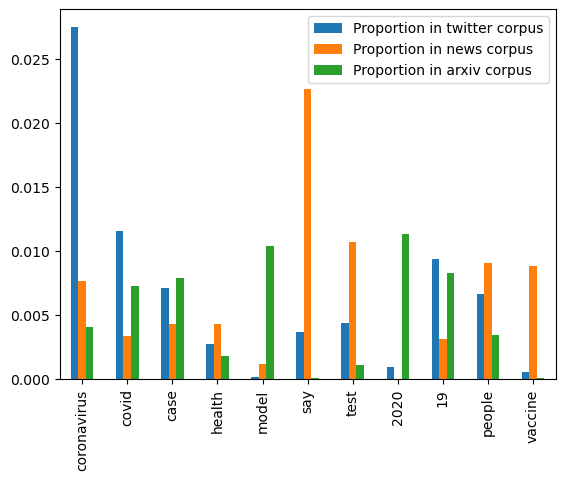

In [32]:
# this cell has been taggged with excluded_from_script
# it will not be run by the autograder
def get_word_frequency_across_corpuses(input_words):    
    twitter_corpus, news_corpus, arxiv_corpus = get_corpuses()
    twitter_corpus_size = sum(len(d) for d in twitter_corpus)
    news_corpus_size = sum(len(d) for d in news_corpus)
    arxiv_corpus_size = sum(len(d) for d in arxiv_corpus)
    twitter_f, news_f, arxiv_f = word_frequency(twitter_corpus), word_frequency(news_corpus), word_frequency(arxiv_corpus)
    return pd.DataFrame({
        "Proportion in twitter corpus" : [twitter_f.get(word, 0) / twitter_corpus_size for word in input_words],
        "Proportion in news corpus" : [news_f.get(word, 0) / news_corpus_size for word in input_words],
        "Proportion in arxiv corpus" : [arxiv_f.get(word, 0) / arxiv_corpus_size for word in input_words]
    }, index = input_words)

df_frequency = get_word_frequency_across_corpuses([
    "coronavirus", "covid", "case", "health", "model", "say", "test",
    "2020", "19", "people", "vaccine"
])

display(df_frequency)

df_frequency.plot(kind='bar')

We see that there are differences across datasets in the relative frequency of each term. "Coronavirus" is used most frequently in tweets, "say" most frequently in news corpus, and perhaps unsurprisingly, "model" most frequently in arxiv papers. The scientific notation of coronavirus, "covid," isn't used in news articles as much, but is equally popular in both tweets and arxiv papers. On the other hand, "health" sees most frequent usage in news articles, likely due to health advice-related articles. Feel free to edit the word list above and see what other insights you can derive!

We now move to the last step of data collection and preparation: constructing input features to be used for more formal analyses and language modeling. As language modeling will be covered later in the course, here we will only cover two simple feature construction methods: term frequency (TF) and term frequency - inverse document frequency (TF-IDF).

### Question 13: Feature construction: term frequency (TF)
Implement the function `construct_tf_matrix` that takes as input a corpus and outputs a matrix $TF$ where each row corresponds to one document, and each column corresponds to one of the unique words in the entire corpus. $TF_{ij}$ is the number of times word $j$ appears in document $i$. Similar to the previous question, rare words that only appear once in the entire corpus should be removed, i.e., there should be no columns for those words.

**Notes**:
* The rows should be ordered based on the document ordering in the corpus. Row 0 corresponds to `corpus[0]`, row 1 to `corpus[1]`, and so on.
* The columns should be ordered based on the alphabetical order of their corresponding words. Column 0 corresponds to the alphabetically first word in the corpus, column 1 to the alphabetically second word, and so on.
* To ensure code efficiency, avoid using too many loops. Take advantage of Pandas and Numpy functionalities.

In [33]:
def construct_tf_matrix(corpus):
    """
    Construct a term frequency matrix from an input corpus
    
    args:
        corpus (List[List[str]]) : a nested list of word tokens, where each inner list is a document
    
    return:
        np.array[n_documents, n_words] : the term frequency matrix
    """
    corpus_dict = word_frequency(corpus)
    unique_words = corpus_dict.keys()
    unique_words = sorted(unique_words)
    
    tf_matrix = np.zeros((len(corpus),len(unique_words)),dtype=np.int64)
    
    for doc_index, document in enumerate(corpus):
        for words in document:
            if words in unique_words:
                col_index = unique_words.index(words)
                tf_matrix[doc_index, col_index] +=1
                
    return tf_matrix
    
    

In [34]:
def test_construct_tf_matrix():
    corpus = [
        "this project is project 4 in foundations of computational data science".split(),
        "it covers text data collection and preparation in the data science pipeline".split(),
        "text processing can be tricky sometimes".split()
    ]
    tf = construct_tf_matrix(corpus)
    assert (tf == np.array([
        [1, 1, 2, 1, 0],
        [2, 1, 0, 1, 1],
        [0, 0, 0, 0, 1]]
    )).all()
    
    twitter_corpus, news_corpus, arxiv_corpus = get_corpuses()
    all_corpuses = twitter_corpus + news_corpus + arxiv_corpus
    tf = construct_tf_matrix(all_corpuses)
    assert tf.dtype == np.int64
    assert tf.shape == (10021, 9871), tf.shape
    assert (tf.sum(axis = 1)[:10] == np.array([9, 14, 10, 17, 27, 4, 22, 23, 17, 13])).all(), tf.sum(axis = 1)[:10]
    assert (tf.sum(axis = 1)[-10:] == np.array([1465, 1935, 4681, 1857, 2093, 2496, 1993, 2324, 1809, 3369])).all(), tf.sum(axis = 1)[-10:]
    print("All tests passed!")

test_construct_tf_matrix()

All tests passed!


### Question 14: Feature construction: term frequency - inverse document frequency (TF-IDF)
We can now compute the TF-IDF matrix, which scales the columns of the term frequency matrix by their inverse document frequency. Recall that the inverse document frequency of a word $j$ is computed as
$$\text{IDF}_j = \log \left( \frac{\# \text{ of documents}}{\# \text{ of documents with word } j} \right),$$
and so the $\text{TF-IDF}_{ij}$ entry in the tf-idf matrix is computed as
$$\text{TF-IDF}_{ij} = \text{TF}_{ij} \times \text{IDF}_j.$$

Implement the function `tf_idf_matrix` which takes as input a TF matrix and outputs the corresponding TF-IDF matrix.

In [35]:
def construct_tf_idf_matrix(tf_matrix):
    """
    Compute the term frequency - inverse document frequency in a corpus
    
    args:
        tf_matrix (np.array[n_documents, n_words]) : the term frequency document of the corpus
    
    return:
        np.array[n_documents, n_words] : the tf-idf matrix
    """
    no_of_docs = tf_matrix.shape[0]
    docs_wordj = np.count_nonzero(tf_matrix > 0, axis=0)
    idf = np.log(no_of_docs/docs_wordj)
    tf_idf = tf_matrix * idf
    return tf_idf
   
    

In [36]:
def test_construct_tf_idf_matrix():
    corpus = [
        "this project is project 4 in foundations of computational data science".split(),
        "it covers text data collection and preparation in the data science pipeline".split(),
        "text processing can be tricky sometimes".split()
    ]
    tf_idf = construct_tf_idf_matrix(construct_tf_matrix(corpus))
    assert np.allclose(tf_idf, np.array([
        [0.40546511, 0.40546511, 2.19722458, 0.40546511, 0.        ],
        [0.81093022, 0.40546511, 0.        , 0.40546511, 0.40546511],
        [0.        , 0.        , 0.        , 0.        , 0.40546511]
    ]))
    print("All tests passed!")
    
test_construct_tf_idf_matrix()

All tests passed!
